Episode 1/100, Total reward: -1510.2944251437873
Episode 2/100, Total reward: -1607.4532032392929
Episode 3/100, Total reward: -1551.0758677847623
Episode 4/100, Total reward: -1068.0130304534382
Episode 5/100, Total reward: -1298.1210637788206
Episode 6/100, Total reward: -1416.0074965565364
Episode 7/100, Total reward: -1237.6305587246113
Episode 8/100, Total reward: -1416.497086116459
Episode 9/100, Total reward: -797.1117766322118
Episode 10/100, Total reward: -1494.1560751546272
Episode 11/100, Total reward: -1494.3128067320563
Episode 12/100, Total reward: -130.09825355254017
Episode 13/100, Total reward: -248.83099796171902
Episode 14/100, Total reward: -254.39619424866203
Episode 15/100, Total reward: -2.6022307173216075
Episode 16/100, Total reward: -127.13754915241107
Episode 17/100, Total reward: -1492.226572534927
Episode 18/100, Total reward: -129.04732376475675
Episode 19/100, Total reward: -441.26687742292285
Episode 20/100, Total reward: -128.0188688647027
Episode 21/10

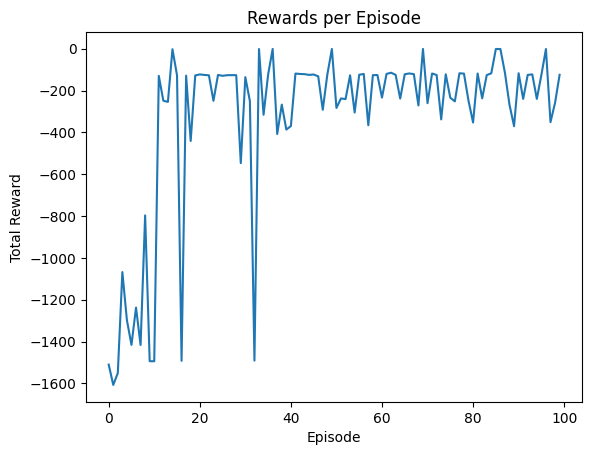

In [5]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

#DDPGG agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, action_bound):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.gamma = 0.99
        self.tau = 0.005
        self.memory = []
        self.memory_size = 1000000
        self.batch_size = 64
        self.actor = self.build_actor()
        self.critic = self.build_critic()
        self.target_actor = self.build_actor()
        self.target_critic = self.build_critic()
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

        self.update_target_network(tau=1)

#Actor Model

    def build_actor(self):
        model = tf.keras.Sequential([
            layers.Dense(400, activation='relu', input_shape=(self.state_dim,)),
            layers.Dense(300, activation='relu'),
            layers.Dense(self.action_dim, activation='tanh')
        ])
        return model

#Critic Model

    def build_critic(self):
        state_input = layers.Input(shape=(self.state_dim,))
        action_input = layers.Input(shape=(self.action_dim,))
        concat = layers.Concatenate()([state_input, action_input])
        out = layers.Dense(400, activation='relu')(concat)
        out = layers.Dense(300, activation='relu')(out)
        out = layers.Dense(1)(out)
        return tf.keras.Model(inputs=[state_input, action_input], outputs=out)

    def update_target_network(self, tau=None):
        tau = self.tau if tau is None else tau
        new_actor_weights = []
        actor_weights = self.actor.get_weights()
        target_actor_weights = self.target_actor.get_weights()
        for i in range(len(actor_weights)):
            new_actor_weights.append(tau * actor_weights[i] + (1 - tau) * target_actor_weights[i])
        self.target_actor.set_weights(new_actor_weights)

        new_critic_weights = []
        critic_weights = self.critic.get_weights()
        target_critic_weights = self.target_critic.get_weights()
        for i in range(len(critic_weights)):
            new_critic_weights.append(tau * critic_weights[i] + (1 - tau) * target_critic_weights[i])
        self.target_critic.set_weights(new_critic_weights)

    def store_transition(self, state, action, reward, next_state, done):
        if len(self.memory) >= self.memory_size:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = np.expand_dims(state, axis=0).astype(np.float32)
        action = self.actor(state)[0]
        return action.numpy() * self.action_bound

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = np.random.choice(len(self.memory), self.batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.memory[i] for i in batch])

        states = np.array(states, dtype=np.float32)
        actions = np.array(actions, dtype=np.float32)
        rewards = np.array(rewards, dtype=np.float32).reshape(-1, 1)
        next_states = np.array(next_states, dtype=np.float32)
        dones = np.array(dones, dtype=np.float32).reshape(-1, 1)

        not_dones = 1 - dones
        next_actions = self.target_actor(next_states)
        q_values_next = self.target_critic([next_states, next_actions])
        q_values_next = rewards + self.gamma * q_values_next * not_dones

        with tf.GradientTape() as tape:
            q_values = self.critic([states, actions], training=True)
            critic_loss = tf.keras.losses.MSE(q_values, q_values_next)

        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            actions_pred = self.actor(states, training=True)
            q_values_pred = self.critic([states, actions_pred], training=True)
            actor_loss = -tf.reduce_mean(q_values_pred)

        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

        self.update_target_network()

#Training the Agent

def train(agent, env, episodes):
    rewards = []
    for e in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.store_transition(state, action, reward, next_state, done)
            agent.replay()
            state = next_state
            total_reward += reward

        rewards.append(total_reward)
        print(f"Episode {e+1}/{episodes}, Total reward: {total_reward}")

    return rewards

# Main Script

if __name__ == "__main__":
    env = gym.make("Pendulum-v1",render_mode="human")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_bound = env.action_space.high[0]

    agent = DDPGAgent(state_dim, action_dim, action_bound)
    episodes = 100
    rewards = train(agent, env, episodes)

#Plot the results
    plt.plot(rewards)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()
